https://www.census.gov/programs-surveys/nsch/data/datasets.2020.html#list-tab-491554181

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
# topical is detailed questionnaire of  one sampled child from the screener
topical_2022 = pd.read_stata('.\\datasets\\2022\\nsch_2022e_topical.dta')
# topical_2022 = pd.read_stata('./datasets/2022/nsch_2022e_topical.dta')
topical_2021 = pd.read_stata('.\\datasets\\2021\\nsch_2021e_topical.dta')

# # combined dataset
# df = pd.concat([topical_2022, topical_2021])

# topical_2022.keys() #490
# topical_2021.keys() #463

In [4]:
data = topical_2022.copy()

In [5]:
# Pre-processing
# imputer = SimpleImputer(strategy='mean')
# data_final = pd.DataFrame(imputer.fit_transform(data_final), columns = data_final.columns)

In [6]:
# Combine diagnosis and severity into a new target variable ranging from 0 to 3
data['k2q31a'] = data['k2q31a'].apply(lambda x: 0 if x == 2 else 1) #assign 0 to 'No' instead of 2
data['ADD_SEVERITY'] = data['k2q31a'] * data['k2q31c'].fillna(0)
target_variable = 'ADD_SEVERITY'

# don't include: stratum (1 or 2a), householdid, formtype (1-3), k2q31d (add medication), any of previous targets
ex_features = ['stratum', 'hhid', 'formtype', 'addtreat', 'k2q31d', 'k2q31a', 'k2q31c', 'k2q34c', 'k2q31b']
data = data.drop(columns = ex_features)

Exploratory Data Analysis


In [ ]:
# making ADD indicator variable (true/false)
data['ADD_IND'] = data['ADD_SEVERITY'] != 0

# grouping by fips code for state distribution of ADD/population (prevalence)
fips_group = data.groupby(['fipsst'])
fips_add_freq = fips_group['ADD_IND'].sum() / fips_group['fipsst'].sum()
# fips_add_freq = (fips_add_freq.to_frame(name='ADD_FREQ')).reset_index()
fips_add_freq = (np.log(fips_add_freq.to_frame(name='ADD_FREQ') * 1000)).reset_index()

In [7]:
# calculate n for each target category
noADD = (data[target_variable] == 0).sum()
sev1 = (data[target_variable] == 1).sum()
sev2 = (data[target_variable] == 2).sum()
sev3 = (data[target_variable] == 3).sum()

In [8]:
# Identify features with high correlation with the target

# Convert categorical columns to numerical
data_conv = data.copy()
categ = ['inq_edu', 'inq_employ', 'inq_home', 'inq_income', 'inq_resseg']
data_conv[categ] = data[categ].replace({'LOW': 0, 'HIGH': 1})

correlation_matrix = data_conv.corr()

# Extract the correlation of the target variable with all other variables (exclude the target variable)
target_correlation = correlation_matrix.loc[target_variable].sort_values(ascending=False).drop(target_variable)

highly_correlated_features = target_correlation[abs(target_correlation) > 0.2].index.tolist()

print("Features with high correlation with the target:")
print(highly_correlated_features)

Features with high correlation with the target:
['hcability', 'totcshcn', 'k7q84_r', 'k7q83_r', 'makefriend', 'k8q31', 'k7q04r_r', 'k7q85_r', 'k7q82_r', 'bullied_r', 'k8q32', 'genetic_desc', 'k2q35a_1_years', 'bully', 'hcextent', 'sesplanyr', 'c4q04', 'focuson', 'k2q33c', 'k4q37', 'k6q71_r', 'k2q38c', 'sc_k2q19', 'waitforturn', 'calmdown_r', 'arrangehc', 'k2q34b', 'menbevcov', 'k2q36a', 'k2q35a', 'k7q70_r', 'ace11', 'totnonshcn', 'k4q28x04', 'sc_k2q16', 'distracted', 'k2q32a', 'k4q36', 'errandalone', 'ssidisability', 'sc_k2q20', 'k6q15', 'k2q33a', 'k2q30a', 'k4q22_r', 'autismmed', 'sc_k2q13', 'sc_k2q10', 'sc_cshcn', 'sc_k2q22', 'k2q34a', 'memorycond', 'k4q23']


In [9]:
correlation_matrix.loc['k8q31', target_variable]

0.3266904480974043

C:\Users\Michael\anaconda3\envs\cs590w\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Michael\anaconda3\envs\cs590w\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Michael\anaconda3\envs\cs590w\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


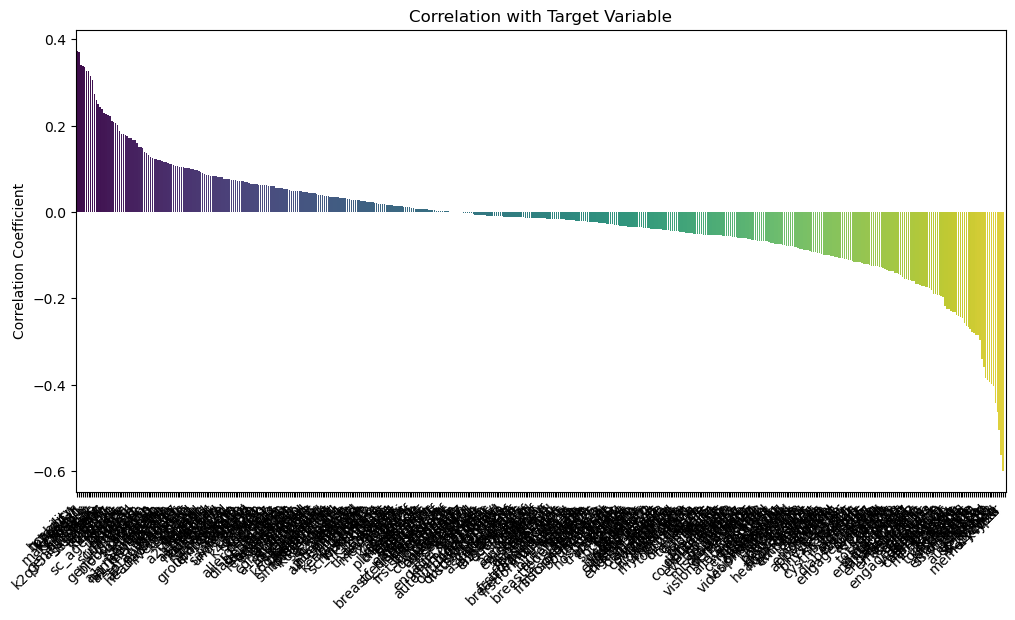

In [10]:
# Visualize Correlations with target variable
plt.figure(figsize=(12, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values, palette='viridis')
plt.title('Correlation with Target Variable')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
reduced_features

NameError: name 'reduced_features' is not defined

In [ ]:
#Exclude further features that are co-variates of ADHD
# don't include: k7q85_r (stays calm when challenged), k7q84_r (finishes tasks), k7q83_r (does all homework), 
# hcextent (health problems affect ability), sesplanyr (Spec. Edu Plan start), c4q04 (frustrated getting service), focuson (focus on task),
# k2q33c (anxiety sev), k4q37 (spec. services received), k2q38c (tourettes), sc_k2q19 (special therapy), waitforturn, calmdown_r (trouble calming down)
# arrangehc (hours arranging healthcare), k2q34b (behavior problems), k2q35a (Autism), k7q70_r (argues too much), ace11 (treated unfairly bc health condition), distracted (often dis)
# k2q32a (depression), k4q36 (received spec. service), ssidisability (receive SSI), sc_k2q20 (spec. therapy for condition), 
# k6q15 (spec. educ. plan), k2q33a (anxiety), k2q30a (learning disability), k4q22_r (received treatment), autismmed (ASD medication), sc_k2q13 (use med care)
# sc_k2q10 (medication), sc_cshcn (spec. health care needs), sc_k2q22 (treatment), k2q34a (behavior problem), memorycond (difficulty concentrating), k4q23 (medication)
# menbevcov (insurance cov), k7q04r_r (times school contact home), k7q82_r (cares about grades), genetic_desc (genetic condition), k2q35a_1_years (first told ASD), k2q36a (dev delay)
excluded = ['k7q85_r', 'k7q84_r', 'k7q83_r', 'hcextent', 'sesplanyr', 'c4q04', 'focuson', 'k2q33c', 'k4q37', 'sc_k2q19', 'waitforturn', 'calmdown_r', 'arrangehc', 'k2q34b', 'k2q35a', 
            'k7q70_r', 'ace11', 'distracted', 'k2q32a', 'k4q36', 'ssidisability', 'sc_k2q20', 'k6q15', 'k2q33a', 'k2q30a', 'k4q22_r', 'autismmed', 'sc_k2q13', 'sc_k2q10', 'sc_cshcn', 
            'sc_k2q22', 'k2q34a', 'memorycond', 'k4q23', 'menbevcov', 'k7q04r_r', 'k7q82_r', 'genetic_desc', 'k2q35a_1_years', 'k2q38c', 'k2q36a']
data_ex = data_conv.drop(columns = excluded)
reduced_features = [feature for feature in highly_correlated_features if feature not in excluded]
data_final = data_ex[reduced_features + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_conv.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[reduced_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.4
test_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state = 42)


In [ ]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'{name} - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model.feature_importances_
plt.barh(reduced_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [ ]:
#Logistic Regression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [ ]:
#Gaussian Process Classifier
model = GaussianProcessClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Gaussian Process Classifier - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Linear Kernel
model = SVC(kernel = 'linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Linear) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Polynomial Kernel
model = SVC(kernel = 'poly', degree = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Polynomial) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# Choose the best model and evaluate on the test set
best_model = LogisticRegression(max_iter = 1000)  # Change this based on the best-performing model from validation
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Best Model - Test Accuracy: {accuracy_test:.2f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Mangitude of Coefficients
coefficients = best_model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [ ]:
#Repeat same steps but features are economic variables (n = 393)

data = topical_2022.copy()
# Combine diagnosis and severity into a new target variable ranging from 0 to 3
data['k2q31a'] = data['k2q31a'].apply(lambda x: 0 if x == 2 else 1) #assign 0 to 'No' instead of 2
data['ADD_SEVERITY'] = data['k2q31a'] * data['k2q31c'].fillna(0)
target_variable = 'ADD_SEVERITY'

#select desired variables
economic_features = ['a1_employed', 'ace1', 'currcov', 'cuthours', 'decisions', 'ebtcards', 'everhomeless', 
                     'foodsit', 'fpl_i1', 'homeevic', 'k11q60', 'k11q61', 'k11q62', 
                     'k12q01_a', 'k3q04_r','k3q20', 'k3q21b', 'k3q25', 'k4q27', 'missmortgage', 's9q34', 'ssi', 
                     'tenure']
data_final = data[economic_features + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_final.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[economic_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.4
test_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state = 26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state = 26)



In [ ]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'{name} - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model.feature_importances_
plt.barh(reduced_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [ ]:
#Logistic Regression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [ ]:
#Gaussian Process Classifier
model = GaussianProcessClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Gaussian Process Classifier - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Linear Kernel
model = SVC(kernel = 'linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Linear) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Polynomial Kernel
model = SVC(kernel = 'poly', degree = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Polynomial) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# Choose the best model and evaluate on the test set
best_model = LogisticRegression()  # Change this based on the best-performing model from validation
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Best Model - Test Accuracy: {accuracy_test:.2f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Mangitude of Coefficients
coefficients = best_model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [ ]:
#Repeat same steps but features are parental variables (n = 109)

data = topical_2022.copy()
# Combine diagnosis and severity into a new target variable ranging from 0 to 3
data['k2q31a'] = data['k2q31a'].apply(lambda x: 0 if x == 2 else 1) #assign 0 to 'No' instead of 2
data['ADD_SEVERITY'] = data['k2q31a'] * data['k2q31c'].fillna(0)
target_variable = 'ADD_SEVERITY'

#select desired variables
parental_features = ['a1_age', 'a1_born', 'a1_employed', 'a1_grade', 'a1_liveusa', 
                     'a1_marital','a1_menthealth', 'a1_physhealth', 'a1_relation', 'a1_sex', 'a2_age', 'a2_born', 
                     'a2_employed', 'a2_grade', 'a2_liveusa','a2_marital','a2_menthealth', 'a2_physhealth',
                     'a2_relation', 'a2_sex','ace3', 'ace4', 'ace5', 'ace6', 'ace7','ace8', 'ace9', 'agepos4', 
                     'allergies', 'althealth', 'appointment']
data_final = data[parental_features + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_final.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[parental_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.45
validation_size = 0.3
test_size = 0.25

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size))



In [ ]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'{name} - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model.feature_importances_
plt.barh(parental_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [ ]:
#Logistic Regression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [ ]:
#Gaussian Process Classifier
model = GaussianProcessClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Gaussian Process Classifier - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Linear Kernel
model = SVC(kernel = 'linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Linear) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Polynomial Kernel
model = SVC(kernel = 'poly', degree = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Polynomial) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# Choose the best model and evaluate on the test set
best_model = LogisticRegression()  # Change this based on the best-performing model from validation
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Best Model - Test Accuracy: {accuracy_test:.2f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# # Feature importance
# feature_importance = best_model.feature_importances_
# plt.barh(parental_features, feature_importance)
# plt.xlabel('Feature Importance')
# plt.title('Random Forest - Feature Importance')
# plt.show()

# Mangitude of Coefficients
coefficients = best_model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()


In [ ]:
#Repeat same steps but features are lifestyle variables (n = 12,111)

data = topical_2022.copy()
# Combine diagnosis and severity into a new target variable ranging from 0 to 3
data['k2q31a'] = data['k2q31a'].apply(lambda x: 0 if x == 2 else 1) #assign 0 to 'No' instead of 2
data['ADD_SEVERITY'] = data['k2q31a'] * data['k2q31c'].fillna(0)
target_variable = 'ADD_SEVERITY'

#select desired variables
lifestyle_features = ['avoidchg', 'bedtime', 'birth_yr',
                     'birthwt', 'bmiclass', 'bornusa', 'bullied_r', 'overweight',
                      'bully', 'concussion', 'covidarrange', 'screentime', 'physactiv',
                     'goforhelp', 'height', 'hhcount','higrade_tvis', 'hopeful', 'insgap', 'k10q11', 'k10q12','k10q13', 
                      'k10q14', 'k10q20', 'k10q22', 'k10q23', 'k10q30', 'k10q31', 'k10q40_r', 'k10q41_r', 'k11q43r', 'k2q01', 
                      'k2q05', 'wktosolve', 'sc_age_years', 'placeslived', 'sc_english', 'vape', 'talkabout']
# Convert categorical columns to numerical
data_conv = data.copy()
categ = ['inq_edu', 'inq_employ', 'inq_home', 'inq_income', 'inq_resseg']
data_conv[categ] = data[categ].replace({'LOW': 0, 'HIGH': 1})

data_final = data_conv[lifestyle_features + categ + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_final.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[lifestyle_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.3
test_size = 0.2

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state = 42)


In [ ]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'{name} - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model.feature_importances_
plt.barh(lifestyle_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [ ]:
#Logistic Regression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [ ]:
#Gaussian Process Classifier
model = GaussianProcessClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Gaussian Process Classifier - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Linear Kernel
model = SVC(kernel = 'linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Linear) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Polynomial Kernel
model = SVC(kernel = 'poly', degree = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Polynomial) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# Choose the best model and evaluate on the test set
best_model = LogisticRegression()  # Change this based on the best-performing model from validation
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Best Model - Test Accuracy: {accuracy_test:.2f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Mangitude of Coefficients
coefficients = best_model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [ ]:
# Combining the strongest features from each category
data = topical_2022.copy()
# Combine diagnosis and severity into a new target variable ranging from 0 to 3
data['k2q31a'] = data['k2q31a'].apply(lambda x: 0 if x == 2 else 1) #assign 0 to 'No' instead of 2
data['ADD_SEVERITY'] = data['k2q31a'] * data['k2q31c'].fillna(0)
target_variable = 'ADD_SEVERITY'

#select desired variables
combo_features = ['ace1', 'decisions', 'k4q27',
                     'missmortgage', 'k12q01_a', 'tenure', 'a1_employed', 'a2_physhealth',
                      'a2_menthealth', 'a2_relation', 'bullied_r', 'k11q43r', 'screentime',
                     'bully', 'k2q01', 'sc_age_years', 'totnonshcn', 'k8q31', 'errandalone', 'k8q31']
# Convert categorical columns to numerical
data_conv = data.copy()
categ = ['inq_edu', 'inq_employ', 'inq_home', 'inq_income', 'inq_resseg']
data_conv[categ] = data[categ].replace({'LOW': 0, 'HIGH': 1})

data_final = data_conv[combo_features + [target_variable]]

# Remove rows with missing values
final = data_final.dropna()

# Calculate the number of deleted rows due to NA
original_rows = data_final.shape[0]
deleted_rows = original_rows - final.shape[0]
                                        
X = final[combo_features]
y = final[target_variable]

# Split the dataset into train, validation, and test sets
train_size = 0.5
validation_size = 0.27
test_size = 0.23

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size))


In [ ]:
final

In [ ]:
# Random Forest
model_ = RandomForestClassifier()
model_.fit(X_train, y_train)
y_pred = model_.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'{name} - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Feature importance
feature_importance = model_.feature_importances_
plt.barh(combo_features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [ ]:
feature_importance

In [ ]:
len(comb_features)

In [ ]:
#Logistic Regression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Logistic Regression - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Mangitude of Coefficients
coefficients = model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()

In [ ]:
#Gaussian Process Classifier
model = GaussianProcessClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Gaussian Process Classifier - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Linear Kernel
model = SVC(kernel = 'linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Linear) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# SVM with Polynomial Kernel
model = SVC(kernel = 'poly', degree = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'SVC (Polynomial) - Validation Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [ ]:
# Choose the best model and evaluate on the test set
best_model = LogisticRegression()  # Change this based on the best-performing model from validation
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Best Model - Test Accuracy: {accuracy_test:.2f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Mangitude of Coefficients
coefficients = best_model.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients and feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression - Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels for positive and negative values
for index, value in enumerate(feature_importance['Coefficient']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()